<a href="https://colab.research.google.com/github/aisyahbelajar/Analisis-sentiment-film-merah-putih-one-for-all/blob/main/mix_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen Komentar Youtube pada FIlm Merah Putih One For All




In [213]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Get Data

In [214]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

for fn in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[fn]), encoding='latin-1')
    display(df.head())

Saving youtube-comments-OfficialTrailerMERAHPUTIHONEFORALLCinépolisIndonesia.csv to youtube-comments-OfficialTrailerMERAHPUTIHONEFORALLCinépolisIndonesia (1).csv


,Date,Username,Comment,like
0,2025-09-11T09:53:46Z,@Malaysyetananjing,Gak serius bikin film ð malah yang ada biki...,0
1,2025-09-11T09:48:24Z,@RayNal-y5w,Lebih bagus ejen ali,0
2,2025-09-11T08:05:06Z,@Baceprot14,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,0
3,2025-09-11T07:37:49Z,@bahrunbahrun6858,ini bukan 6&#39;5m malahan 5 ribu rupiah,0
4,2025-09-11T04:59:09Z,@faridalaini-qe9td,Jelek banget grafik nya sama bentuk tokoh nya ...,0


## Pre Processing Data

In [215]:
# Buat kolom clean_text
def clean_text(text):
    text = text.lower()  # jadi huruf kecil semua
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # hapus URL
    text = re.sub(r"@\w+", "", text)  # hapus mention
    text = re.sub(r"#\w+", "", text)  # hapus hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus tanda baca & angka
    text = re.sub(r"\s+", " ", text).strip()  # hapus spasi berlebih
    return text

df['clean_text'] = df['Comment'].apply(clean_text)

# Cek hasilnya
df[['Comment', 'clean_text']].head()

,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,gak serius bikin film malah yang ada bikin kecewa
1,Lebih bagus ejen ali,lebih bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,jir grafik majapahit aokwaokwaowaokawowaw
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,ini bukan m malahan ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,jelek banget grafik nya sama bentuk tokoh nya ...


### Labeling Data with BERT

In [216]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Buat pipeline sentiment
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [217]:
def bert_label(text):
    max_length = tokenizer.model_max_length if hasattr(tokenizer, 'model_max_length') and tokenizer.model_max_length is not None else 512
    truncated_text = text[:max_length]
    result = sentiment_analyzer(truncated_text)[0]  # result = {'label': '5 stars', 'score': 0.85}
    label = result['label']

    # Mapping ke 3 kelas sederhana: 0=negatif, 1=positif, 2=netral
    if label in ['1 star', '2 stars']:
        return 0  # negatif
    elif label == '3 stars':
        return 2  # netral
    else:
        return 1  # positif

df['sentiment_bert'] = df['clean_text'].apply(bert_label)

In [218]:
df[['clean_text', 'sentiment_bert']].head(10)


,clean_text,sentiment_bert
0,gak serius bikin film malah yang ada bikin kecewa,0
1,lebih bagus ejen ali,2
2,jir grafik majapahit aokwaokwaowaokawowaw,2
3,ini bukan m malahan ribu rupiah,0
4,jelek banget grafik nya sama bentuk tokoh nya ...,0
5,wanjir baru sadar ada ak di pojokan,0
6,film hina,1
7,najis dah,2
8,bagusan grafik upin ipin,2
9,cuihh najiss,2


### Manual Labeling

In [219]:
def auto_label_with_bert(text, bert_label_value):
    positif = [ 'keren', 'hebat', 'seru', 'lucu', 'mantap', 'recommended']
    negatif = ['buruk','bangsat', 'kecewa', 'jelek', 'ngebosenin', 'cringe', 'hujat', 'lebih bagus', 'hina', 'bagusan','najis','majapahit','anjir','deepweb','sakit','grafik','konyol','berhenti','malu','burik','buriq','insto','sekarat','monyet','dosa','anjing','koruptor','cok','jumbo','eek','kecewa','anying','jembut','gaje','ngakak','bendera','edan','dislike','aib','kontol','wkwk','rabun','report','ajg','boomer']

    # Kalau ada kata positif/negatif di teks → override hasil BERT
    if any(word in text for word in positif):
        return 1  # positif
    elif any(word in text for word in negatif):
        return 0  # negatif
    else:
        return bert_label_value  # kalau tidak kena rule, pakai hasil BERT

df['sentiment_final'] = df.apply(lambda row: auto_label_with_bert(row['clean_text'], row['sentiment_bert']), axis=1)
df[['clean_text', 'sentiment_bert', 'sentiment_final']].head(20)

,clean_text,sentiment_bert,sentiment_final
0,gak serius bikin film malah yang ada bikin kecewa,0,0
1,lebih bagus ejen ali,2,0
2,jir grafik majapahit aokwaokwaowaokawowaw,2,0
3,ini bukan m malahan ribu rupiah,0,0
4,jelek banget grafik nya sama bentuk tokoh nya ...,0,0
5,wanjir baru sadar ada ak di pojokan,0,0
6,film hina,1,0
7,najis dah,2,0
8,bagusan grafik upin ipin,2,0
9,cuihh najiss,2,0


## TF-IDF

In [220]:
from sklearn.pipeline import FeatureUnion

tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=20000)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=20000)

combined = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])
X = combined.fit_transform(df['clean_text'])
y = df['sentiment_final']


## SMOTE

In [221]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

## Classification with Random Forest

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight="balanced_subsample")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, random_state=42)

In [223]:
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       774
           1       0.64      0.95      0.77       728
           2       0.92      0.66      0.77       726

    accuracy                           0.78      2228
   macro avg       0.82      0.78      0.78      2228
weighted avg       0.82      0.78      0.78      2228

Confusion Matrix:
[[571 174  29]
 [ 23 694  11]
 [ 37 212 477]]


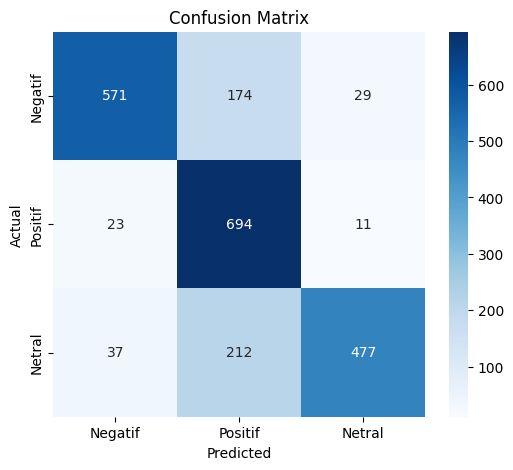

In [224]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Classification with SVM

In [225]:
from sklearn.svm import LinearSVC

svm = LinearSVC(class_weight="balanced", random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.99      0.88      0.93       774
           1       0.88      0.99      0.93       728
           2       0.94      0.93      0.94       726

    accuracy                           0.93      2228
   macro avg       0.94      0.93      0.93      2228
weighted avg       0.94      0.93      0.93      2228



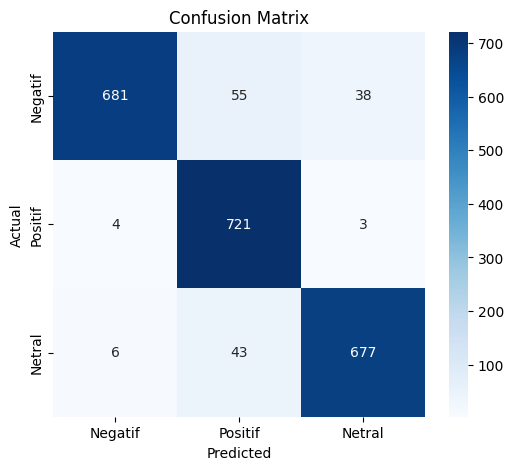

In [226]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Classification with Decision Tree


In [227]:
clf = DecisionTreeClassifier(
    max_depth=50,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=5, random_state=42)

In [228]:
y_pred_dt = clf.predict(X_test)

print(classification_report(y_test, y_pred_dt, digits=3))




              precision    recall  f1-score   support

           0      0.848     0.738     0.789       774
           1      0.712     0.889     0.790       728
           2      0.839     0.747     0.790       726

    accuracy                          0.790      2228
   macro avg      0.800     0.791     0.790      2228
weighted avg      0.801     0.790     0.790      2228



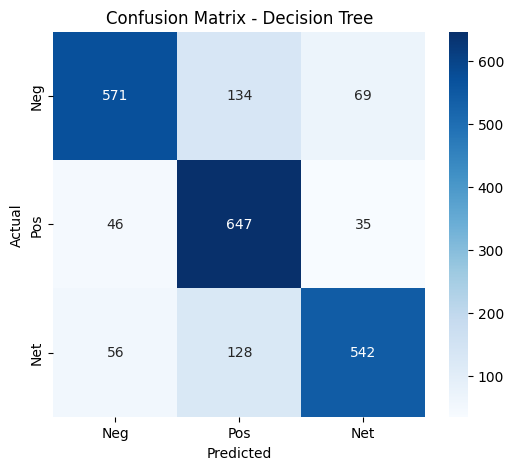

In [229]:
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Neg','Pos','Net'],
            yticklabels=['Neg','Pos','Net'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

## Classification with Naive Bayes

In [230]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       774
           1       0.85      0.67      0.75       728
           2       0.74      0.89      0.81       726

    accuracy                           0.80      2228
   macro avg       0.81      0.80      0.80      2228
weighted avg       0.81      0.80      0.80      2228



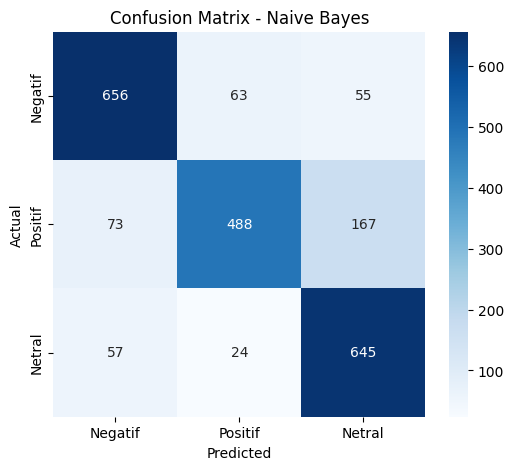

In [231]:
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

## Visualization

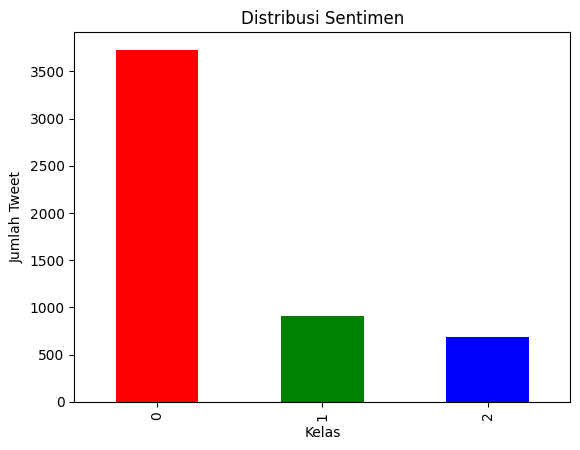

In [210]:
df['sentiment_final'].value_counts().plot(kind='bar', color=['red','green','blue'])
plt.title("Distribusi Sentimen")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Tweet")
plt.show()


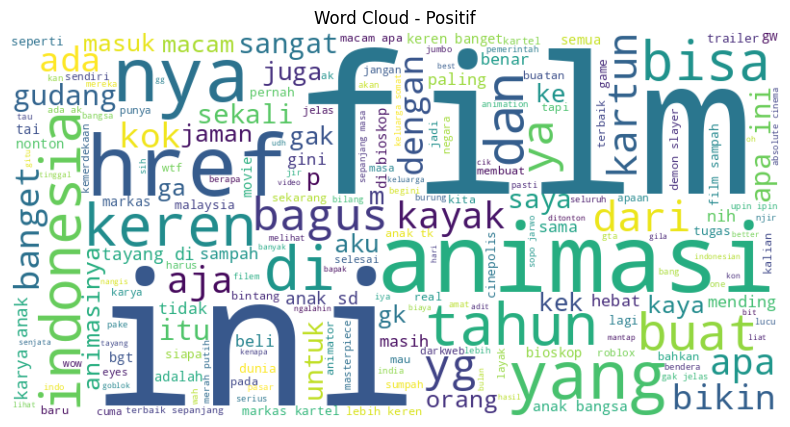

In [211]:
text = " ".join(df[df['sentiment_final']==1]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positif")
plt.show()


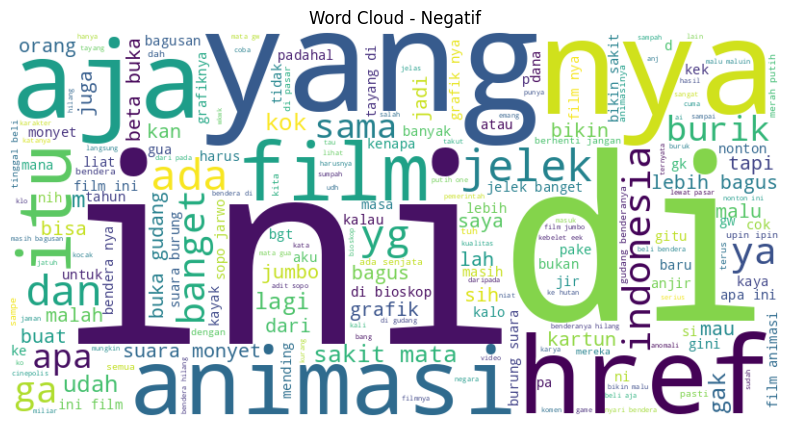

In [212]:
text_neg = " ".join(df[df['sentiment_final']==0]['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(text_neg)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negatif")
plt.show()


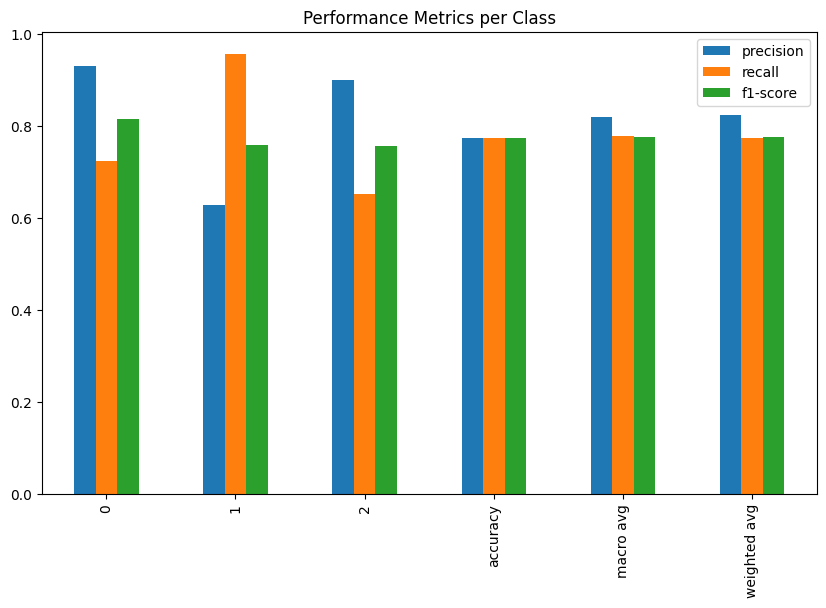

In [188]:
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df[['precision','recall','f1-score']].plot(kind='bar', figsize=(10,6))
plt.title("Performance Metrics per Class")
plt.show()
